# Behavioural Cloning

## Import the modules

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimage
import keras#
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

## Obtain dataset

In [6]:
data_dir = './../../data/self_driving_car/simulator_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\center_2020_12_02_20_53_44_541.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\left_2020_12_02_20_53_44_541.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\right_2020_12_02_20_53_44_541.jpg,0.0,0.0,0,0.000079
1,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\center_2020_12_02_20_53_44_642.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\left_2020_12_02_20_53_44_642.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\right_2020_12_02_20_53_44_642.jpg,0.0,0.0,0,0.000079
2,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\center_2020_12_02_20_53_44_743.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\left_2020_12_02_20_53_44_743.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\right_2020_12_02_20_53_44_743.jpg,0.0,0.0,0,0.000079
3,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\center_2020_12_02_20_53_44_843.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\left_2020_12_02_20_53_44_843.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\right_2020_12_02_20_53_44_843.jpg,0.0,0.0,0,0.000078
4,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\center_2020_12_02_20_53_44_943.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\left_2020_12_02_20_53_44_943.jpg,C:\repos\Jupyter-Playground\data\self_driving_car\simulator_data\IMG\right_2020_12_02_20_53_44_943.jpg,0.0,0.0,0,0.000078


## Format filepath data

In [8]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_12_02_20_53_44_541.jpg,left_2020_12_02_20_53_44_541.jpg,right_2020_12_02_20_53_44_541.jpg,0.0,0.0,0,0.000079
1,center_2020_12_02_20_53_44_642.jpg,left_2020_12_02_20_53_44_642.jpg,right_2020_12_02_20_53_44_642.jpg,0.0,0.0,0,0.000079
2,center_2020_12_02_20_53_44_743.jpg,left_2020_12_02_20_53_44_743.jpg,right_2020_12_02_20_53_44_743.jpg,0.0,0.0,0,0.000079
3,center_2020_12_02_20_53_44_843.jpg,left_2020_12_02_20_53_44_843.jpg,right_2020_12_02_20_53_44_843.jpg,0.0,0.0,0,0.000078
4,center_2020_12_02_20_53_44_943.jpg,left_2020_12_02_20_53_44_943.jpg,right_2020_12_02_20_53_44_943.jpg,0.0,0.0,0,0.000078


## Visualise dataset.
### - Found issue with biased data, having too much with 0 steering. 

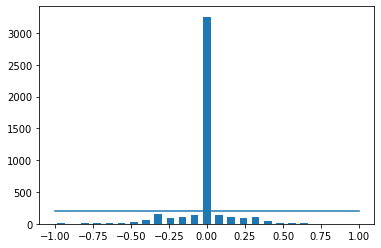

In [19]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)

# Issue with too many 0 angles. Will cause neural network to be biased and drive forward
# Create a threshold on each bin of 200

samples_per_bin = 200
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## Cap each bin at a specific value to prevent biased data

total data:  4380
removed:  3055
remaining:  1325


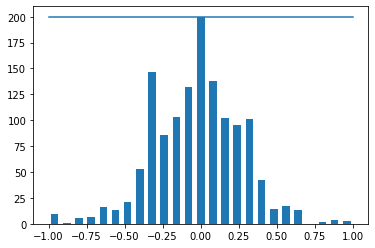

In [27]:
print('total data: ', len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [30]:
print(data.iloc[1])

def load_image_steering(data_dir, df):
    image_path = []
    steering = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(data_dir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_image_steering(data_dir + '/IMG', data)

center      center_2020_12_02_20_53_46_189.jpg
left          left_2020_12_02_20_53_46_189.jpg
right        right_2020_12_02_20_53_46_189.jpg
steering                                     0
throttle                              0.931907
reverse                                      0
speed                                  1.90777
Name: 15, dtype: object


## Create training and test data sets

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 1)

print('Training Samples {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples 1060
Valid Samples: 265


Text(0.5, 1.0, 'Validation set')

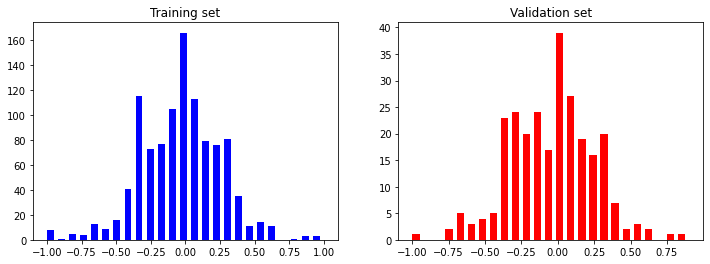

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

## Preprocess Images

In [48]:
def get_image(image_path):
    return npimage.imread(image)

def crop_image(image):
    return image[60:135, :,:]

def yuv_image(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def blur_image(image):
    return cv2.GaussianBlur(image, (3, 3), 0)
    
def resize_image(image):
    return cv2.resize(image, (200, 66))

def normalize_image(image):
    return image / 255

def preprocess_image(image):
    image = get_image(image)
    image = crop_image(image)
    image = yuv_image(image)
    image = blur_image(image)
    image = resize_image(image)
    image = normalize_image(image)
    return image

Text(0.5, 1.0, 'Preprocessed Image')

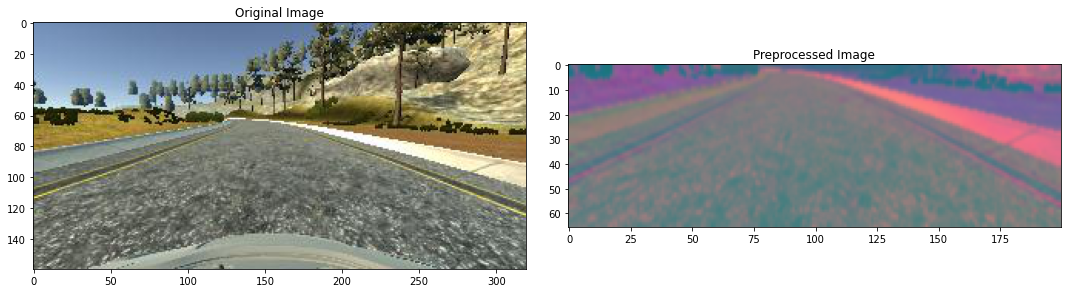

In [49]:
image = image_paths[100]
original_image = npimage.imread(image)
preprocessed_image = preprocess_image(image)

fig, axes = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

## Map preprocess function across dataset

In [50]:
X_train = np.array(list(map(preprocess_image, X_train)))
X_valid = np.array(list(map(preprocess_image, X_valid)))

(1060, 66, 200, 3)


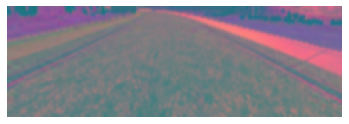

In [60]:
plt.imshow(X_train[random.randint(0, len(X_train - 1))])
plt.axis('off')
print(X_train.shape)

## Create model

In [75]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, kernel_size = (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
    
    model.add(Conv2D(36, kernel_size = (5, 5), strides = (2, 2), activation = 'elu'))
    model.add(Conv2D(48, kernel_size = (5, 5), strides = (2, 2), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'elu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))

    optimizer= Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

In [76]:
model = nvidia_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [77]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid), batch_size = 100, verbose = 1, shuffle = 1)

Epoch 1/30
11/11 [==============================] - 2s 207ms/step - loss: 0.3325 - val_loss: 0.1094
Epoch 2/30
11/11 [==============================] - 2s 188ms/step - loss: 0.1189 - val_loss: 0.0825
Epoch 3/30
11/11 [==============================] - 2s 188ms/step - loss: 0.1063 - val_loss: 0.0823
Epoch 4/30
11/11 [==============================] - 2s 186ms/step - loss: 0.0932 - val_loss: 0.0910
Epoch 5/30
11/11 [==============================] - 2s 186ms/step - loss: 0.0904 - val_loss: 0.0819
Epoch 6/30
11/11 [==============================] - 2s 185ms/step - loss: 0.0925 - val_loss: 0.0818
Epoch 7/30
11/11 [==============================] - 2s 186ms/step - loss: 0.0905 - val_loss: 0.0824
Epoch 8/30
11/11 [==============================] - 2s 188ms/step - loss: 0.0895 - val_loss: 0.0821
Epoch 9/30
11/11 [==============================] - 2s 204ms/step - loss: 0.0907 - val_loss: 0.0829
Epoch 10/30
11/11 [==============================] - 2s 200ms/step - loss: 0.0877 - val_loss: 0.0819

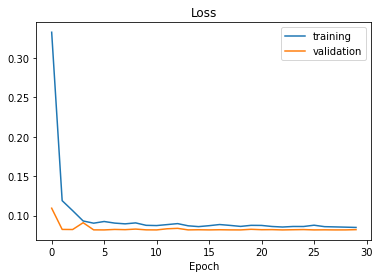

In [78]:
def show_model_loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
def show_model_accuracy_plot(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['training', 'validation'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

show_model_loss_plot(history)

In [79]:
model.save('../../models/cnn/self_driving_car_behavioural_clone') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../models/cnn/self_driving_car_behavioural_clone/assets
